Step 0, Loss 3.253433576063605e+19
Step 100, Loss 3.1463231115275272e+19
Step 200, Loss 3.0431662709026062e+19
Step 300, Loss 2.9438313326958346e+19
Step 400, Loss 2.848077283958404e+19
Step 500, Loss 2.7557862570438164e+19
Step 600, Loss 2.6667429675753538e+19
Step 700, Loss 2.580818332887915e+19
Step 800, Loss 2.4978502849675657e+19
Step 900, Loss 2.4177090814422286e+19


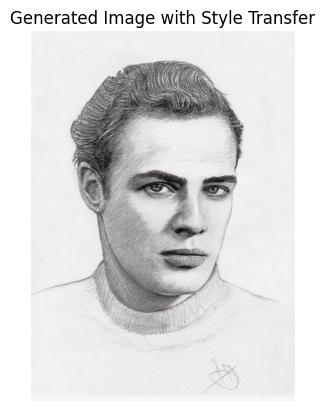

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image as kp_image
from tensorflow.keras.applications import vgg19
#from google.colab import drive # Import drive for mounting Google Drive

# Mount Google Drive
#drive.mount('/content/drive')

# Load content and style images
style_image_path = r'"C:\Users\Dell\OneDrive\Pictures\Screenshots\Screenshot 2025-05-26 164744.png"'  # Replace with your image path
content_image_path = r'"C:\Users\Dell\OneDrive\Pictures\Screenshots\Screenshot 2025-02-17 034214.png"'      # Replace with your image path

content_image = kp_image.load_img(content_image_path.strip('"'))
style_image = kp_image.load_img(style_image_path.strip('"'))

# Preprocess the images for VGG19
def preprocess_image(img):
    img = kp_image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

content_array = preprocess_image(content_image)
style_array = preprocess_image(style_image)

# Set up the VGG19 model
model = vgg19.VGG19(weights='imagenet', include_top=False)

# Get the layers for style and content extraction
content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

def get_model(layers):
    outputs = [model.get_layer(name).output for name in layers]
    return tf.keras.models.Model([model.input], outputs)

content_model = get_model(content_layers)
style_model = get_model(style_layers)

# Define loss functions and optimization
def compute_content_loss(content, generated):
    return tf.reduce_mean(tf.square(content - generated))

def compute_style_loss(style, generated):
    gram_style = tf.linalg.einsum('bijc,bijd->bcd', style, style)
    gram_generated = tf.linalg.einsum('bijc,bijd->bcd', generated, generated)
    return tf.reduce_mean(tf.square(gram_style - gram_generated))

# Combine style and content losses for total loss calculation
def compute_total_loss(content_weight=1.0, style_weight=1.0):
    content_loss = compute_content_loss(content_array, generated_image)
    style_loss = compute_style_loss(style_array, generated_image)
    total_loss = content_weight * content_loss + style_weight * style_loss
    return total_loss

# Perform optimization and transfer the style to the content image
generated_image = tf.Variable(content_array)  # Initialize with content image
optimizer = tf.optimizers.Adam(learning_rate=0.01)

for i in range(1000):
    with tf.GradientTape() as tape:
        total_loss = compute_total_loss()
    grads = tape.gradient(total_loss, generated_image)
    optimizer.apply_gradients([(grads, generated_image)])
    if i % 100 == 0:
        print(f"Step {i}, Loss {total_loss.numpy()}")
def deprocess_image(processed_img):
    x = processed_img.copy()
    # Remove batch dimension
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    # Undo preprocessing by VGG19
    x[:, :, 0] += 103.939  # B
    x[:, :, 1] += 116.779  # G
    x[:, :, 2] += 123.68   # R
    x = x[:, :, ::-1]  # BGR to RGB
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# Convert the generated image to displayable format
generated_image_np = generated_image.numpy()
final_img = deprocess_image(generated_image_np)


# Display the result
plt.imshow(final_img)
plt.title("Generated Image with Style Transfer")
plt.axis('off')
plt.show()